In [1]:
import numpy as np
from collections import Counter
from itertools import product
from qiskit import *
from qiskit.algorithms.optimizers import SPSA
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,15)
import seaborn as sns
#import numpy as np
RANDOM_STATE = 25
np.random.seed(RANDOM_STATE)

In [2]:
class SPSACallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

## Generating  random data 

In [3]:
from generate_data import gaussian_copula,convert_data_to_binary_string,empirical_distribution

P_3 = np.array([[ 1.0, 0.3,  0.2],
              [0.3,  1.0,  -0.7],
              [ 0.2,  -0.7,  1.0]])

P_2 = np.array([[ 1.0, -0.7],
              [-0.7,1]])
NUM_QUBITS_VAR = 3
NUM_VARS = len(P_2)
NUM_TRAINING_SAMPLES = 10000

cholesky,Z, U, G = gaussian_copula(NUM_TRAINING_SAMPLES,P_2)
binary_samples = convert_data_to_binary_string(U,NUM_QUBITS_VAR)
target_probs = empirical_distribution(binary_samples, NUM_QUBITS_VAR*NUM_VARS)

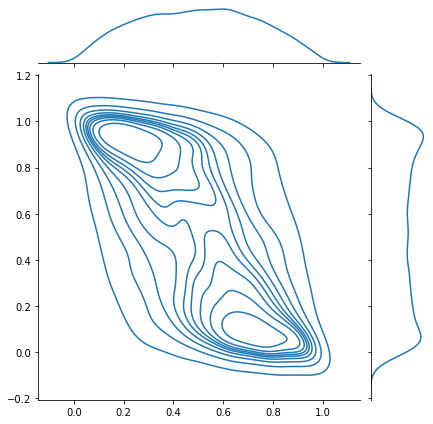

In [4]:
sns.jointplot(x=U[:,1], y=U[:,0], kind="kde");

In [5]:
NUM_LAYERS = 2
NUM_SHOTS = 2048
spsa_cbk = SPSACallback()
spsa = SPSA(maxiter=600,callback=spsa_cbk.callback,learning_rate = 0.1,perturbation=0.1)

## Optimizing the QCBM model

In [6]:
from qcbm import QCBM

qcbm_model = QCBM(NUM_QUBITS_VAR,NUM_VARS,NUM_LAYERS,NUM_SHOTS,target_probs)
cost_function = qcbm_model.cost_function
initial_params = 2*np.pi*np.random.rand(3, NUM_QUBITS_VAR*NUM_VARS, NUM_LAYERS).flatten()
result = spsa.minimize(cost_function, initial_params)

## Visualizing the loss curve

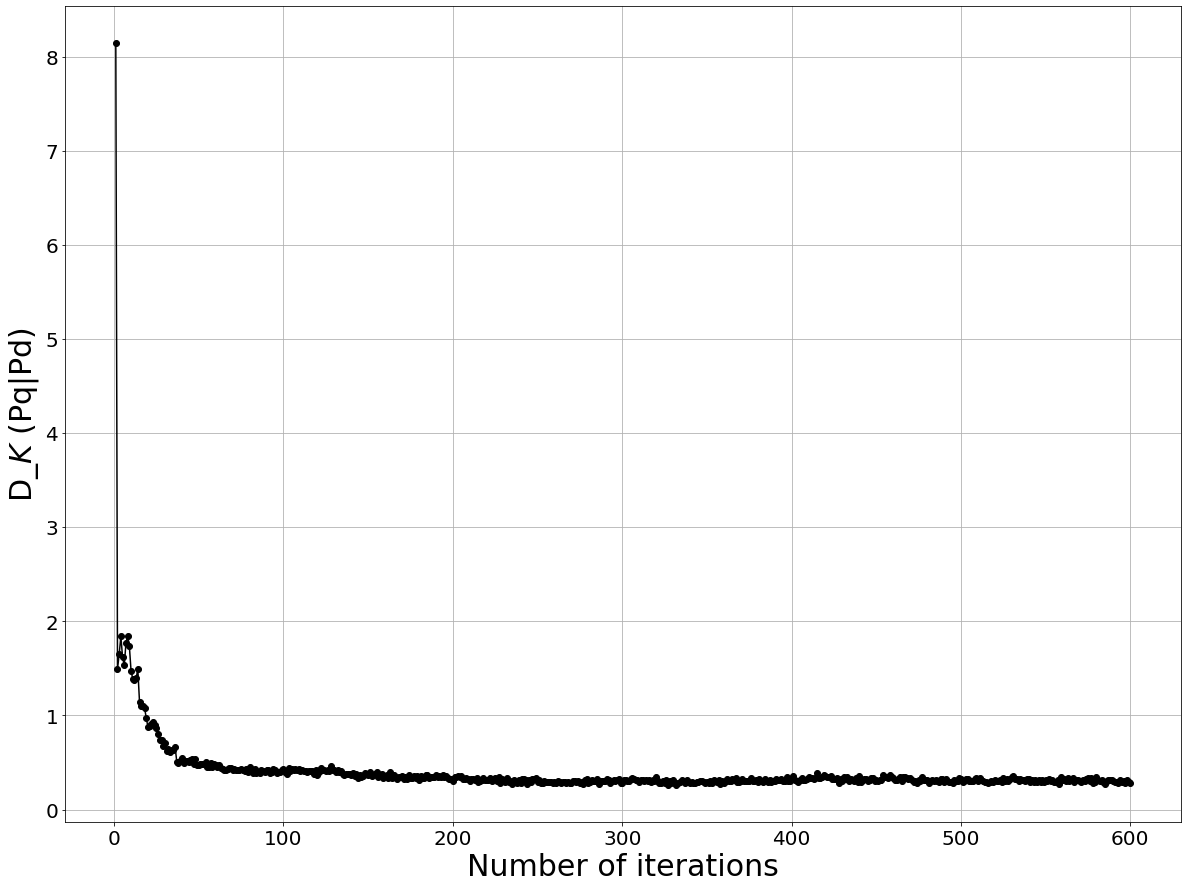

In [7]:
plt.rcParams["figure.figsize"] = (20,15)
plot_data = spsa_cbk.get_callback_data()  # callback data
plt.rcParams["font.size"] = 30
plt.plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
plt.xlabel("Number of iterations")
plt.ylabel("D_$K$ (Pq|Pd)")
plt.xticks(size=20)
plt.yticks(size=20)
plt.grid()
plt.show()

## Comparing learned and target distributions

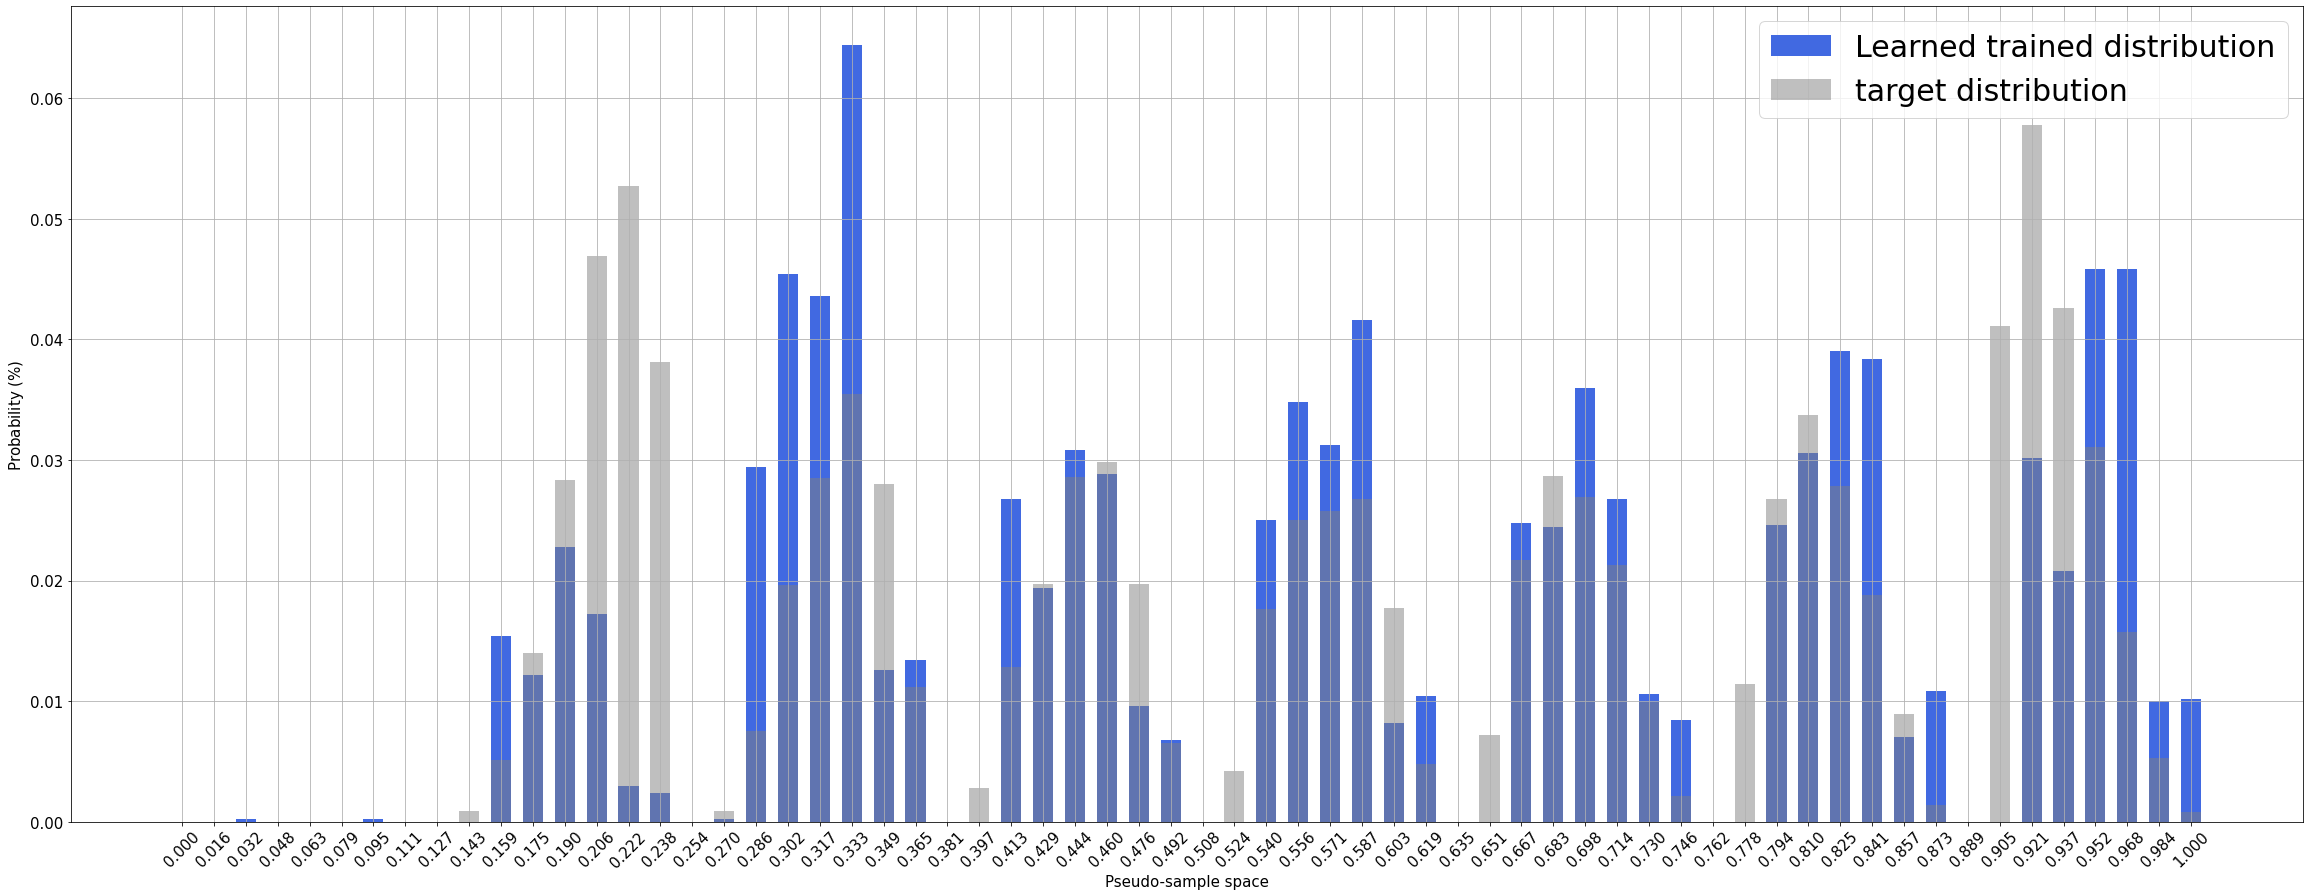

In [8]:
# Evaluate trained probability distribution by comapring histograms 
plt.rcParams["figure.figsize"] = (40,15)
bounds = [0,1]
num_qubits = NUM_QUBITS_VAR*NUM_VARS

x = [bounds[0] + (bounds[1] - bounds[0]) * x / (2**num_qubits - 1) for x in range(2**num_qubits)]

opt_params = result.x
y = qcbm_model.estimate_distribution(opt_params,num_shots= 5000)
# Plot distributions
plt.bar(x, y, width=0.01, label="Learned trained distribution", color="royalblue")
plt.xticks(x, size=15, rotation=45)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Pseudo-sample space", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.bar(x,target_probs,width=0.01,color="grey",label="target distribution",alpha = 0.5)
plt.legend(loc="best")
plt.show()

In [9]:
print(result)

{   'fun': 0.2966921960543624,
    'jac': None,
    'nfev': 1800,
    'nit': 600,
    'njev': None,
    'x': array([ 5.58727992,  0.91352306,  2.52135958,  4.84910485, -0.68396237,
        1.44300803,  0.13683453,  1.39388284,  1.97763521,  6.42656209,
        4.45406288,  5.57951322,  5.83050819,  3.69989881,  2.5444937 ,
        2.5058546 ,  2.71914467,  3.228527  ,  1.06571065,  2.06516583,
        1.62741378,  3.1527547 ,  2.51018114,  4.47630642,  5.37332004,
        6.77268952,  4.70380638,  6.00139725,  2.43653508,  2.46198907,
        1.34427201,  1.28967784,  3.62540537,  2.13048143,  1.0586637 ,
        6.73584922])}


## Sampling from the QCBM after reverse probability integral transform and compare with original random data

In [10]:
print(target_probs)

[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.0009
 0.0051 0.014  0.0283 0.0469 0.0527 0.0381 0.     0.0009 0.0075 0.0196
 0.0285 0.0355 0.028  0.0112 0.     0.0028 0.0128 0.0197 0.0286 0.0298
 0.0197 0.0065 0.     0.0042 0.0176 0.025  0.0258 0.0268 0.0177 0.0048
 0.     0.0072 0.0217 0.0287 0.0269 0.0213 0.0099 0.0021 0.     0.0114
 0.0268 0.0337 0.0278 0.0188 0.0089 0.0014 0.     0.0411 0.0578 0.0426
 0.0311 0.0157 0.0053 0.0008]
